In [104]:
import numpy as np
import pandas as pd
from collections import defaultdict
from gensim.models import KeyedVectors
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Use the pre-trained Google News corpus (3 billion running words) word vector model

Estimated Time: 10 seconds

In [105]:
def create_word2vec_model():
    word2vec_path = 'GoogleNews-vectors-negative300.bin'
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    return w2v_model

Create a list of connections games from the connections.csv

In [106]:
def create_connections_games():
    df = pd.read_csv('connections.csv', names=['word0', 'word1', 'word2', 'word3', 'clue'], keep_default_na=False).iloc[1:]
    df = df[['word0', 'word1', 'word2', 'word3']]
    words_list = df.stack().tolist()
    words_list = [s.lower() for s in words_list]
    games = [words_list[i:i+16] for i in range(0, len(words_list), 16)]
    return games


Create word embeddings from pre-trained word2vec model

In [107]:
def create_w2v_embeddings(w2v_model, games):
    embeddings = []
    for i, word_set in enumerate(games):
        embeddings.append([])
        for word in word_set:
            if word in w2v_model:
                embeddings[i].append(w2v_model[word])
            else:
                embeddings[i].append([0 for _ in range(300)])

    np_embeddings = []
    for word_set in embeddings:
        np_embeddings.append(np.array(word_set))
    
    return np_embeddings

Performs K means constrianed clustering for one game (Required size 4 for clusters)

In [108]:
def kmeans_clustering(X, game, visualize=False, reduction='pca'):
    kmeans_cluster = KMeansConstrained(n_clusters=4, size_min=4, size_max=4)
    cluster_labels = kmeans_cluster.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)

    clusters = {}
    for i, word in enumerate(game):
        cluster_label = cluster_labels[i]
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(word)
    clusters = dict(sorted(clusters.items()))

    if visualize:
        visualize_clusters(X, game, cluster_labels, reduction)

    return clusters, sil_score 

Plays all the Connections games and performs K-means constrained clustering on each Connections game

In [109]:
def play_connections(connections_games, word_embeddings, metrics):
    game_results = []
    for i, game in enumerate(connections_games):
        clusters, sil_score = kmeans_clustering(word_embeddings[i], game)
        game_results.append(clusters)
        metrics["silhouette_score"].append(sil_score)
    return game_results, metrics

Evaluate results of playing all the Connections game

In [110]:
def evaluate_connections(connections_games, results, metrics):
    for i, game in enumerate(connections_games):
        result = results[i]
        
        true_list = [set() for _ in range(len(game) // 4)]
        for i, item in enumerate(game):
            true_list[i // 4].add(item)
        
        pred_list = [set(value) for value in result.values()]

        match_set_count = 0
        for true_set in true_list:
            if true_set in pred_list:
                match_set_count += 1
        
        metrics["correct_groups"].append(match_set_count)
        
    return metrics 

Visualize the clusters created by one Connections game through dimensionality reduction

Option of PCA or T-SNE

In [111]:
def visualize_clusters(X, game, cluster_labels, reduction):
    if reduction == 'pca':
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        plt.title('Kmeans Clustering on Word2Vec - PCA Visualization')
    else:
        tsne = TSNE(perplexity=3)
        X_reduced = tsne.fit_transform(X)
        plt.title('Kmeans Clustering on Word2Vec - T-SNE Visualization')

    for cluster_label in np.unique(cluster_labels):
        plt.scatter(X_reduced[cluster_labels == cluster_label, 0], X_reduced[cluster_labels == cluster_label, 1], 
        label=f'Cluster {cluster_label}', alpha=0.5)

    for i, word in enumerate(game):
        plt.annotate(word, (X_reduced[i, 0], X_reduced[i, 1]))

    plt.legend(bbox_to_anchor=(1, 1))
    plt.savefig('./visualizations/word2vec-cluster-visualization.png')

Create histogram of the correct group accuracies from all the Connections games played

In [112]:
def visualize_group_accuracy(num_correct_groups):
    labels, counts = np.unique(num_correct_groups, return_counts=True)
    frequencies = counts / counts.sum()
    percentages = frequencies * 100
    colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green']
    rects = plt.bar([str(l) for l in labels], percentages, color = colors)
    plt.bar_label(rects, padding = 0.5, labels = [f"{p:.2f}%" for p in percentages])
    plt.title("Group Prediction Accuracy")
    plt.xlabel("Number of Groups Correctly Predicted")
    plt.ylabel("Relative Frequency (%)")
    plt.savefig('./visualizations/word2vec-group-accuracies.png')

Create histogram to visualize the silhouette scores from all the Connections games played

In [113]:
def visualize_silhouette_score(scores):
    plt.hist(scores)
    plt.title("Silhouette Score Distribution")
    plt.xlabel("Silhouette Score")
    plt.ylabel("Count")
    plt.savefig('./visualizations/word2vec-silhouette-scores.png')

In [114]:
w2v_model = create_word2vec_model()

In [115]:
connections_games = create_connections_games()

In [116]:
word_embeddings = create_w2v_embeddings(w2v_model, connections_games)

In [117]:
metrics = defaultdict(list)
results, metrics = play_connections(connections_games, word_embeddings, metrics)

In [118]:
metrics = evaluate_connections(connections_games, results, metrics)

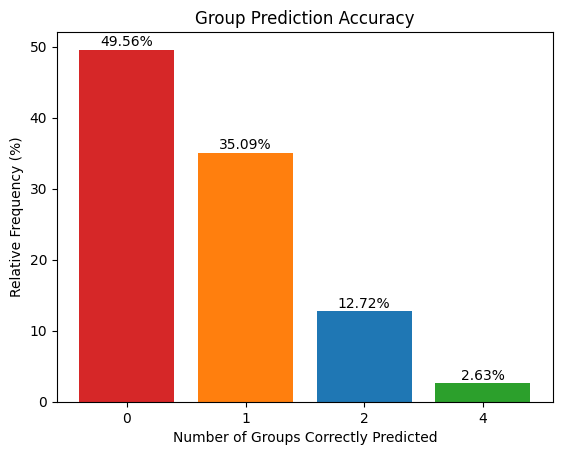

In [119]:
visualize_group_accuracy(metrics["correct_groups"])

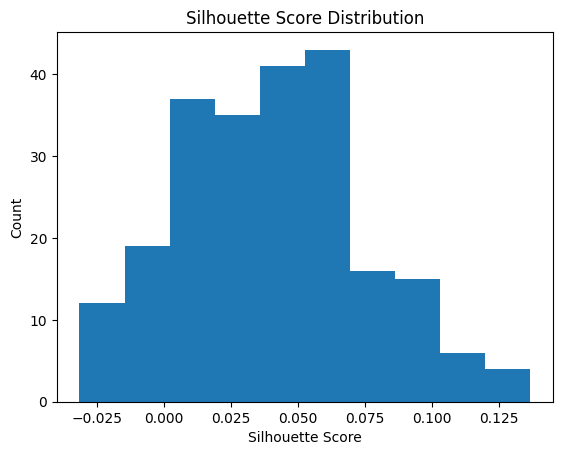

In [120]:
visualize_silhouette_score(metrics["silhouette_score"])

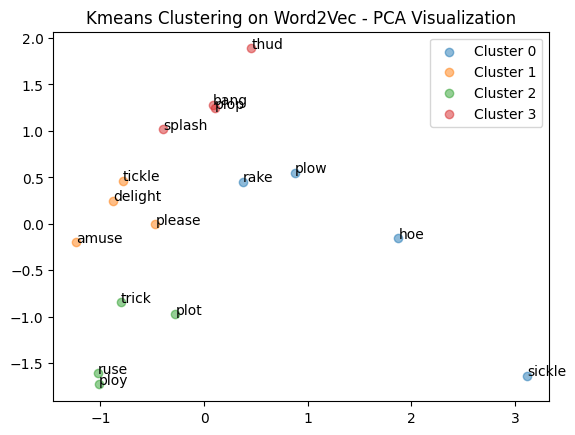

In [121]:
clusters, sil_score = kmeans_clustering(word_embeddings[40], connections_games[40], visualize=True, reduction='pca')

In [122]:
def advanced_metrics(runs=1):
    w2v_model = create_word2vec_model()
    connections_games = create_connections_games()
    metrics = defaultdict(list)
    total_metrics = defaultdict(list)
    for i in range(runs):
        print(f'Run {i}')
        word_embeddings = create_w2v_embeddings(w2v_model, connections_games)
        results, metrics = play_connections(connections_games, word_embeddings, metrics)
        metrics = evaluate_connections(connections_games, results, metrics)

        labels, counts = np.unique(metrics['correct_groups'], return_counts=True)
        frequencies = counts / counts.sum()
        percentages = frequencies * 100

        total_metrics["none-correct"].append(percentages[0])
        total_metrics["one-correct"].append(percentages[1])
        total_metrics["two-correct"].append(percentages[2])
        total_metrics["all-correct"].append(percentages[3])

    mean_metrics = {}
    std_metrics = {}
    confidence_metrics = {}
    for key in total_metrics:
        mean_metrics[key] = np.mean(total_metrics[key])
        std_metrics[key] = np.std(total_metrics[key])
    
    for key in mean_metrics:
        margin_error = 2.33 * (std_metrics[key]/(runs ** 0.5))
        lower_bound = mean_metrics[key] - margin_error
        upper_bound = mean_metrics[key] + margin_error
        confidence_metrics[key] = (lower_bound, upper_bound)
    
    print(f"Mean of Group Accuracies (Percentages): {mean_metrics}")
    print(f"Standard Deviation of Group Accuracies (Percentages): {std_metrics}")
    print(f"Confidence Interval of Group Accuracies (Percentages): {confidence_metrics}")
    return mean_metrics, std_metrics, confidence_metrics

In [123]:
def visualize_advanced_metrics(mean_metrics, std_metrics, confidence_metrics):
    labels = [0, 1, 2, 4]
    mean_values = list(mean_metrics.values())
    std_values = list(std_metrics.values()) 
    conf_intervals = [(ci[1]- ci[0])/2 for ci in confidence_metrics.values()]
    print(conf_intervals)

    colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green']
    rects = plt.bar([str(l) for l in labels], mean_values, color = colors, yerr=conf_intervals, capsize=5)
    plt.bar_label(rects, padding = 0.5, labels = [f"{p:.2f}%" for p in mean_values])

    plt.title("Group Prediction Accuracy")
    plt.xlabel("Number of Groups Correctly Predicted")
    plt.ylabel("Relative Frequency (%)")
    plt.show()



In [124]:
mean_metrics, std_metrics, confidence_metrics = advanced_metrics(runs=50)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Mean of Group Accuracies (Percentages): {'none-correct': 49.52367433702871, 'one-correct': 32.787668333403296, 'two-correct': 13.639487851169674, 'all-correct': 4.049169478398326}
Standard Deviation of Group Accuracies (Percentages): {'none-correct': 0.33280962838227185, 'one-correct': 0.848255506115797, 'two-correct': 0.4142562887983102, 'all-correct': 0.2519294013939056}
Confidence Interval of Group Accuracies (Percentages): {'none-correct': (49.414009650624564, 49.63333902343285), 'one-correct': (32.50815816862546, 33.067178498181136), 'two-correct': (13.502985532343033, 13.775990169996316), 'all-correct': (3.9661557779409775, 4.132183178855675)}


[0.10966468640414462, 0.2795101647778395, 0.13650231882664166, 0.08301370045734857]


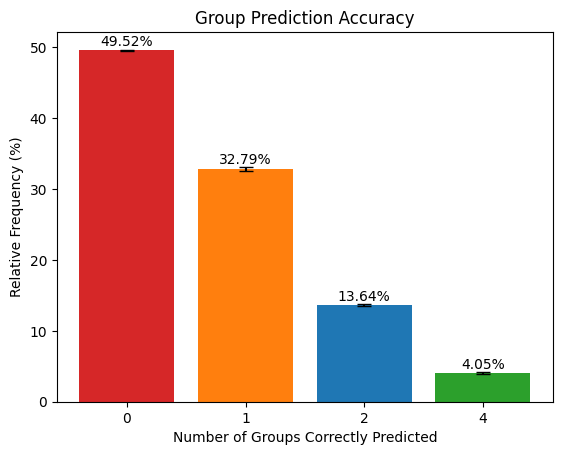

In [125]:
visualize_advanced_metrics(mean_metrics, std_metrics, confidence_metrics)